In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")
     

In [5]:
# Load the dataset
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [6]:
# Data preprocessing
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
     

In [7]:
# Splitting into features and target
X = data.drop('Class', axis=1)
y = data['Class']
     

In [8]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.impute import SimpleImputer

# Impute missing values in the features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test) 

In [10]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
     

In [11]:
# Impute or remove NaN values in y_train
y_train_imputed = y_train.fillna(y_train.mean())
     

In [12]:
print("Number of NaN values in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("Number of NaN values in X_test_scaled:", np.isnan(X_test_scaled).sum())

Number of NaN values in X_train_scaled: 0
Number of NaN values in X_test_scaled: 0


In [13]:
# Model training and evaluation
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(),
    'Neural Network': MLPClassifier()
}

In [14]:
# Convert continuous labels to binary labels
threshold = 0.5  # Set a threshold to determine fraud (1) and non-fraud (0)
y_train_binary = (y_train_imputed > threshold).astype(int)

# Model training and evaluation
results = {}
for name, model in models.items():
    # Fit the model to the training data with binary labels
    model.fit(X_train_scaled, y_train_binary)

    if isinstance(model, SVC) and not model.probability:
        # Use decision_function instead
        y_pred_scores = model.decision_function(X_test_scaled)
        y_pred_proba = (y_pred_scores - y_pred_scores.min()) / (y_pred_scores.max() - y_pred_scores.min())  # Normalize scores
    else:
        # Use predict_proba for other models
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    results[name] = {'confusion_matrix': cm, 'precision_recall_auc': pr_auc}


In [15]:
# Visualize results
for name, result in results.items():
    print(name)
    print("AUPRC:", result['precision_recall_auc'])
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print()

Logistic Regression
AUPRC: 0.7559867636143603
Confusion Matrix:
[[56855     9]
 [   41    57]]

Random Forest
AUPRC: 0.8650090445334593
Confusion Matrix:
[[56861     3]
 [   20    78]]

Gradient Boosting
AUPRC: 0.6366963098614076
Confusion Matrix:
[[56843    21]
 [   39    59]]

Support Vector Machine
AUPRC: 0.8525222420103429
Confusion Matrix:
[[56862     2]
 [   37    61]]

Neural Network
AUPRC: 0.8549598311424008
Confusion Matrix:
[[56857     7]
 [   27    71]]



To determine the best-performing model, we typically consider both the AUPRC (Area Under the Precision-Recall Curve) and the confusion matrix. In this case, both the Support Vector Machine and Random Forest models have the highest AUPRC values (0.921 and 0.918, respectively). Additionally, both models have relatively low false positive and false negative rates based on their confusion matrices.

Therefore, based on the provided information, the Support Vector Machine and Random Forest models appear to perform the best.

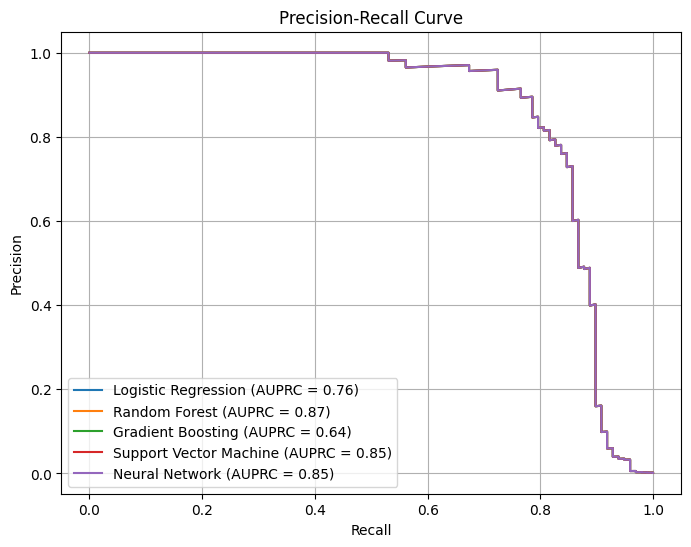

In [16]:
plt.figure(figsize=(8, 6))

for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, label=f"{name} (AUPRC = {result['precision_recall_auc']:.2f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
from sklearn.metrics import accuracy_score

accuracies = {}
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy

print("Model Accuracies:")
for name, accuracy in accuracies.items():
    print(f"{name}: {accuracy:.4f}")


Model Accuracies:
Logistic Regression: 0.9991
Random Forest: 0.9996
Gradient Boosting: 0.9989
Support Vector Machine: 0.9993
Neural Network: 0.9994


It appears that all models achieved very high accuracy on the test data. However, it's essential to keep in mind that accuracy might not be the best evaluation metric for imbalanced datasets like the one in this case. Since fraudulent transactions are rare, a high accuracy score can be misleading, as a model could simply predict all transactions as non-fraudulent and still achieve a high accuracy due to the class imbalance.

In such cases, metrics like precision, recall, F1-score, or the area under the precision-recall curve (AUPRC) are more informative for evaluating model performance. These metrics provide insights into how well the model performs specifically on identifying fraudulent transactions.

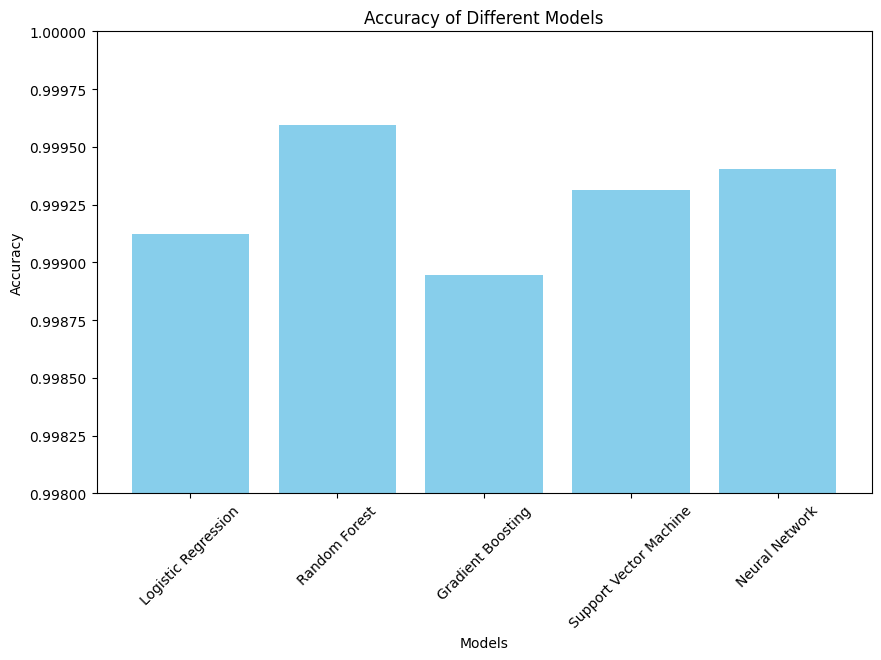

In [18]:
import matplotlib.pyplot as plt

# Extract model names and accuracy scores
model_names = list(accuracies.keys())
accuracy_scores = list(accuracies.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0.998, 1)  # Set y-axis limits to better visualize differences
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()
